# Siamese Neural Network Recommendation for Friends

This notebook creates a new dataset with randomly created groups of users that will represent friends that want to watch a movie together. In the end of the notebook, we tune hyperparameters in order to find the ones that give the best precision and accuracy of the model.

In [1]:
import pandas as pd
import json
import datetime, time
from sklearn.model_selection import train_test_split
import itertools
import os
import zipfile
import random
import numpy as np
from itertools import islice
import requests
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS, SpectralEmbedding, Isomap, LocallyLinearEmbedding, TSNE
import pygsp

import scipy.sparse as sp
from sklearn.metrics import roc_auc_score

import seaborn as sns; sns.set(style="white", color_codes=True)

---

## (1) Read data

Helper methods for our dataframes:

In [2]:
def people_lists_by_roles(row, role_type):
    """Create columns that are roles, and the content is the people that had that role. E.g. column name `actor`
    for a certain movie has a list of people names that were actors in that movie."""
    people = []
    for p in row['cast']:
        if p['cast_role']==role_type:
            if isinstance(p['cast_name'], str):
                people.append(("".join([p['cast_name'].split(', ')[-1]] + p['cast_name'].split(', ')[:-1])).lower())
    return people    

def company_lists_by_county(row):
    """Collect the companies"""
    country = []
    for p in row['company']:
        if isinstance(p['country'], str):
            country.append(p['country'])
    return country   

def create_soup(x):
    """Make a long string containing keywords, casts' names, and companies"""
    ret_val = ''
    for s in soup_columns:
        ret_val += ' '.join(x[s])
    return ret_val

def weighted_rating(m=None, C=None):
    """Used for finding trending movies"""
    def _inner(x):
        """Calculation based on the IMDB formula"""
        v = x['count']
        R = x['mean']
        return (v/(v+m) * R) + (m/(m+v) * C)
    return _inner

## (1.1) Movie dataframe

Create dataframe that will contain movies with their  titles, release dates, genres, poster urls and metadata soup string that will be later used to find vector representation in form of int features. We will feed it to our vectorizer.

In [3]:
df_movies = pd.read_csv("data/movies_cast_company.csv", encoding='utf8')
df_movies["cast"] = df_movies["cast"].apply(lambda x: json.loads(x))
df_movies["company"] = df_movies["company"].apply(lambda x: json.loads(x))
df_movies = df_movies.drop_duplicates("movie_id_ml")

df_roles = pd.read_csv("data/role_type.csv", encoding='utf8', names=['id', 'role'])
roles = list(df_roles['role'].unique())
soup_columns = ['keyword'] + roles + ['company_country'] + ['director']*3
for r in roles:
    df_movies[r] = df_movies.apply(lambda row: people_lists_by_roles(row, r), axis=1)
df_movies['company_country'] = df_movies.apply(lambda row: company_lists_by_county(row), axis=1)
df_movies["keyword"] = df_movies.apply(lambda x: eval(x['keyword']), axis=1)
df_movies['soup'] = df_movies.apply(lambda x: create_soup(x), axis=1)

# get posters
df_posters = pd.read_csv("data/movie_poster.csv", names=["movie_id_ml", "poster_url"])
df_movies = pd.merge(df_movies, df_posters, on="movie_id_ml")

df_movies['soup_id'] = df_movies.index
columns = ['movie_id_ml', 'title', 'release', 'url', 'unknown', 'action',
       'adventure', 'animation', 'childrens', 'comedy', 'crime', 'documentary',
       'drama', 'fantasy', 'noir', 'horror', 'musical', 'mystery', 'romance',
       'scifi', 'thriller', 'war', 'western',
       'poster_url', 'soup', 'soup_id']
df_movies = df_movies[columns]

print(df_movies.shape)
df_movies.tail()

(1251, 26)


movie_id_ml                 title  release  \
1246         1421          mi vida loca     1993   
1247         1533    de eso no se habla     1993   
1248         1560       coup de torchon     1981   
1249         1575  yo, la peor de todas     1990   
1250         1635                  1986     1986   

                                                    url  unknown  action  \
1246  http://us.imdb.com/M/title-exact?Mi%20vida%20l...        0       0   
1247  http://us.imdb.com/M/title-exact?De%20Eso%20No...        0       0   
1248  http://us.imdb.com/M/title-exact?Coup%20de%20t...        0       0   
1249  http://us.imdb.com/M/title-exact?Yo,%20la%20Pe...        0       0   
1250  http://us.imdb.com/M/title-exact?Two%20Friends...        0       0   

      adventure  animation  childrens  comedy  ...  musical  mystery  romance  \
1246          0          0          0       0  ...        0        0        0   
1247          0          0          0       0  ...        0        0        0   
1248          0          0          0       0  ...        0        0        0   
1249          0          0          0       0  ...        0        0        0   
1250          0          0          0       0  ...        0        0        0   

      scifi  thriller  war  western  \
1246      0         0    0        0   
1247      0         0    0        0   
1248      0         0    0        0   
1249      0         0    0        0   
1250      0         0    0        0   

                                             poster_url  \
1246  https://images-na.ssl-images-amazon.com/images...   
1247  https://images-na.ssl-images-amazon.com/images...   
1248  https://images-na.ssl-images-amazon.com/images...   
1249  https://images-na.ssl-images-amazon.com/images...   
1250  https://images-na.ssl-images-amazon.com/images...   

                                                   soup  soup_id  
1246  title-directed-by-female death-of-child murder...     1246  
1247  title-directed-by-female small-town argentinaa...     1247  
1248  face-slap based-on-novel murder bare-breasts b...     1248  
1249  title-directed-by-female marriage mother-son-r...     1249  
1250  number-in-titlerogermuddconniechung mariashriv...     1250  

[5 rows x 26 columns]

We use the `CountVectorizer()` instead of `TF-IDF`. This is because we do not want to down-weight the presence of an actor/director if he or she has acted or directed in relatively more movies. It doesn't make much intuitive sense.

In [4]:
count = CountVectorizer(stop_words='english')#, ngram_range=(3, 3))
count_matrix = count.fit_transform(df_movies['soup'])

In [5]:
print(len(count.get_feature_names()))

83272


In [6]:
soup_movie_features = count_matrix

## (1.2) Ratings dataframe

In [7]:
df_ratings = pd.read_csv("data/ratings.csv")

# TODO: just temporary, later remove
df_ratings.rating_timestamp = df_ratings.rating_timestamp.apply(lambda x: int(time.mktime(datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").timetuple())))

print(df_ratings.shape)
df_ratings.head()

(100000, 4)


user_id  movie_id_ml  rating  rating_timestamp
0      196          242       3         881247349
1      186          302       3         891710542
2       22          377       1         878883516
3      244           51       2         880603323
4      166          346       1         886393996

## (1.3) Users dataframe

In [8]:
df_users = pd.read_csv("data/users.csv")

# columns = ['user_id', 'user_age', 'user_gender', 'user_occupation', 'user_zipcode']
columns = ['user_id', 'user_age', 'user_gender', 'user_occupation', 'user_zipcode']

# TODO: just temporary, later remove
df_users = df_users[columns]

num2occupation = dict(enumerate(df_users.user_occupation.unique()))
occupation2num = {y:x for x,y in num2occupation.items()}
num2gender = dict(enumerate(df_users.user_gender.unique()))
gender2num = {y:x for x,y in num2gender.items()}
df_users.user_occupation = df_users.user_occupation.apply(lambda x: occupation2num[x])
df_users.user_gender = df_users.user_gender.apply(lambda x: gender2num[x])


print(df_users.shape)
df_users.head()

(943, 5)


user_id  user_age  user_gender  user_occupation user_zipcode
0        1        24            0                0        85711
1        2        53            1                1        94043
2        3        23            0                2        32067
3        4        24            0                0        43537
4        5        33            1                1        15213

## (1.4) Calculate a trending score

This type of recommender provides a general chart of recommended movies to **all users**. This is not sensitive to the interests and tastes of a particular user. We will use this as a general recommendation **before** user fills in the data required to predict the movies he/she likes - a.k.a. **Trending Now!**

We can use the average ratings of the movie as the score but using this won't be fair enough since a movie with 3.9 average rating and only 2 votes cannot be considered better than the movie with 2.8 as as average rating but 100 votes.

We will be using the IMDb's weighted rating given as:

$$ w = \frac{v}{v+m}\cdot R + \frac{m}{v+m} \cdot C$$

where:
- $w$ is the weighted average of the movie;
- $v$ is the number of votes for the movie;
- $m$ is the min votes required to be listed in this chart (we can calculate);
- $R$ is the average rating of the movie;
- $C$ is the mean vote accross the whole dataset (we can calculate).

In [9]:
# get trending score
df_mr = pd.merge(df_movies, df_ratings, on="movie_id_ml")
df_mr = pd.merge(df_mr, df_users, on="user_id")
_dfm = df_mr.groupby(["movie_id_ml", "title"], as_index=False)["rating"].agg(["count", "mean"]).reset_index()

C = _dfm["mean"].mean()
m = _dfm["count"].quantile(0.9)
_df_movies_1 = _dfm.copy().loc[_dfm["count"] > m]
df = pd.merge(df_movies, _df_movies_1, on=["movie_id_ml", "title"])
# Define a new feature 'score' and calculate its value with `weighted_rating()`
df_movies['trending_score'] = df.apply(weighted_rating(m, C), axis=1)

## (1.5) Create Friends dataframe

Friends dataframe is created using a random grouping of users from user dataframe in groups sized between 2 to 8 members.

In [10]:
def create_friends_mapping():
    """Randomly unite from 2 to 8 different users into friends group"""

    def slice_by_lengths(lengths, the_list):
        for length in lengths:
            new = []
            for i in range(length):
                new.append(the_list.pop(0))
            yield new

    user_ids = list(df_users.user_id.unique())
    random.shuffle(user_ids)
    lengths = []

    # collect different group lengths to later randomly unite them using user_ids
    for i in range(len(user_ids)):
        length = random.randint(2, 8)

        if sum(lengths) + length > len(user_ids):
            length = len(user_ids) - sum(lengths)
            lengths.append(length)
            break
        elif sum(lengths) + length == len(user_ids):
            lengths.append(length)
            break
        else:
            lengths.append(length)
    
    # now, unite users depending on the group size and choosen number of users to create friends groups
    friend_ids = [i for i in enumerate(slice_by_lengths(lengths, user_ids))]

    # create mapping user id -> friend group id
    user2friendsid = {}
    for fid_and_uids in friend_ids:
        for uid in fid_and_uids[1]:
            user2friendsid[uid] = fid_and_uids[0]
            
    return user2friendsid

In [12]:
df_friends = df_users.copy()
#df_friends = pd.DataFrame()
user2friendsid = create_friends_mapping()
df_friends["friend_id"] = df_friends.apply(lambda x: user2friendsid[x.user_id], axis=1)

fid2avgage = dict(df_friends.groupby("friend_id")["user_age"].agg(np.median))
df_friends["friends_age"] = df_friends.apply(lambda x: fid2avgage[x.friend_id], axis=1)

fid2gender = dict(df_friends.groupby("friend_id")["user_gender"].agg(np.mean))
df_friends["friends_gender"] = df_friends.apply(lambda x: fid2gender[x.friend_id], axis=1)

# TODO: collect user occupation as well??
###

df_friends = df_friends[["friend_id", "friends_age", "friends_gender"]].drop_duplicates()

print(df_friends.shape)
df_friends.head()

(184, 3)


friend_id  friends_age  friends_gender
0        159         36.0            0.40
1          2         35.5            0.25
2        139         32.5            0.25
3        109         26.5            0.50
4        110         30.0            0.40

## (1.5) Ratings dataframe updated with friends voting

Now, we need to modify the ratings dataframe and put friend ids instead of single users ids.

In [13]:
df_ratings_friends = df_ratings.copy()
df_ratings_friends["friend_id"] = df_ratings_friends.apply(lambda x: user2friendsid[x.user_id], axis=1)

fid2medianrating = dict(df_ratings_friends.groupby(["friend_id","movie_id_ml"])["rating"].agg(np.median))
df_ratings_friends["rating"] = df_ratings_friends.apply(lambda x: fid2medianrating[(x.friend_id, x.movie_id_ml)], axis=1)

df_ratings_friends = df_ratings_friends[["movie_id_ml", "rating", "friend_id"]].drop_duplicates()

print(df_ratings_friends.shape)
df_ratings_friends.head()

(69655, 3)


movie_id_ml  rating  friend_id
0          242     3.0         22
1          302     4.0          4
2          377     2.0         24
3           51     2.0         92
4          346     4.0        114

## (1.6) Create raw data from dataframes

Now, we are left with `df_movies`, `df_friends`, `df_ratings_friends` that will be used for the training.

In [14]:
mids = list(df_movies.movie_id_ml.unique())
fids = list(df_friends.friend_id.unique())
df_ratings_friends = df_ratings_friends[df_ratings_friends.movie_id_ml.isin(mids)].drop_duplicates()
df_ratings_friends = df_ratings_friends[df_ratings_friends.friend_id.isin(fids)].drop_duplicates()

fids = list(df_ratings_friends.friend_id.unique())
mids = list(df_ratings_friends.movie_id_ml.unique())
df_movies = df_movies[df_movies.movie_id_ml.isin(mids)].drop_duplicates()
df_friends = df_friends[df_friends.friend_id.isin(fids)].drop_duplicates()

In [15]:
movies = list(df_movies.T.to_dict().values())
friends = list(df_friends.T.to_dict().values())
ratings = list(df_ratings_friends.T.to_dict().values())

In [16]:
print(len(movies), len(friends), len(ratings))

1251 184 59281


Let's see the contents keys of these lists of dictionaries we will work on:

In [17]:
for line in islice(movies, 1):
    print(json.dumps(line, indent=4))

{
    "movie_id_ml": 1,
    "title": "toy story",
    "release": 1995,
    "url": "http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)",
    "unknown": 0,
    "action": 0,
    "adventure": 0,
    "animation": 1,
    "childrens": 1,
    "comedy": 1,
    "crime": 0,
    "documentary": 0,
    "drama": 0,
    "fantasy": 0,
    "noir": 0,
    "horror": 0,
    "musical": 0,
    "mystery": 0,
    "romance": 0,
    "scifi": 0,
    "thriller": 0,
    "war": 0,
    "western": 0,
    "poster_url": "https://images-na.ssl-images-amazon.com/images/M/MV5BMDU2ZWJlMjktMTRhMy00ZTA5LWEzNDgtYmNmZTEwZTViZWJkXkEyXkFqcGdeQXVyNDQ2OTk4MzI@..jpg",
    "soup": "walkie-talkie boy slow-motion villain-turns-good 1990s little-boy little-girl neighbor blockbuster dog rescue bedroom cult-film product-placement torture cowboy tough-guy friendship loyalty violence single-mother christmas family-relationships redemption fight bad-guy yelling wilhelm-scream brawl fist-fight hero jealousy karate martial-arts mild-violenc

In [18]:
for line in islice(friends, 1):
    print(json.dumps(line, indent=4))

{
    "friend_id": 159.0,
    "friends_age": 36.0,
    "friends_gender": 0.4
}


In [19]:
for line in islice(ratings, 1):
    print(json.dumps(line, indent=4))

{
    "movie_id_ml": 302.0,
    "rating": 4.0,
    "friend_id": 4.0
}


Save data for future use:

In [20]:
with open('movies.json', 'w') as f:
    json.dump(movies, f)
    
with open('friends.json', 'w') as f:
    json.dump(friends, f)
    
with open('ratings.json', 'w') as f:
    json.dump(ratings, f)
    
#np.save("soup_movie_features_11.npy", soup_movie_features)
sp.save_npz('soup_movie_features_11.npz', soup_movie_features)

In [21]:
movies = json.load(open('movies.json'))
friends = json.load(open('friends.json'))
ratings = json.load(open('ratings.json')) 
soup_movie_features = sp.load_npz('soup_movie_features_11.npz')
soup_movie_features = soup_movie_features.toarray()

---

## (2) Train the LightFM model

We will be using the [LightFM](http://lyst.github.io/lightfm/docs/index.html) implementation of SiameseNN to train our model using the user and item (i.e. movie) features. First, we create `scipy.sparse` matrices from raw data and they can be used to fit the LightFM model.

In [22]:
from lightfm.data import Dataset
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score
from lightfm.cross_validation import random_train_test_split

## (2.1) Build ID mappings

We create a mapping between the user and item ids from our input data to indices that will be internally used by this model. This needs to be done since the LightFM works with user and items ids that are consecutive non-negative integers. Using `dataset.fit` we assign internal numerical id to every user and item we passed in.

In [23]:
dataset = Dataset()

In [24]:
item_str_for_eval = "x['title'],x['release'], x['unknown'], x['action'], x['adventure'],x['animation'], x['childrens'], x['comedy'], x['crime'], x['documentary'], x['drama'],  x['fantasy'], x['noir'], x['horror'], x['musical'],x['mystery'], x['romance'], x['scifi'], x['thriller'], x['war'], x['western'], *soup_movie_features[x['soup_id']]"
#str_for_eval = "x['title']"
friend_str_for_eval = "x['friends_age'], x['friends_gender']"

In [25]:
dataset.fit(users=(int(x['friend_id']) for x in friends),
            items=(int(x['movie_id_ml']) for x in movies),
            item_features=(eval("("+item_str_for_eval+")") for x in movies),
            user_features=((eval(friend_str_for_eval)) for x in friends))

In [26]:
num_friends, num_items = dataset.interactions_shape()
print(f'Num friends: {num_friends}, num_items {num_items}.')

Num friends: 184, num_items 1251.


## (2.2) Build the interactions train and test data as well as feature matrices

The `interactions` matrix contains interactions between `friend_id` and `movie_id_ml`. It puts 1 if friends `friend_id` rated movie `movie_id_ml`, and 0 otherwise. We split this `interactions` matrix into train and test sets to measure the performance of our model.

In [27]:
(interactions, weights) = dataset.build_interactions(((int(x['friend_id']), int(x['movie_id_ml']))
                                                      for x in ratings))

In [28]:
interactions, interactions_test = random_train_test_split(interactions, test_percentage=0.2)

The `item_features` is also a sparse matrix that contains movie ids with their corresponding features. In the item features, we include the following features: movie title, when it was released, all genres it belongs to, and vectorized representation of movie keywords, cast members, and countries it was released in.

In [29]:
item_features = dataset.build_item_features(((x['movie_id_ml'], 
                                              [eval("("+item_str_for_eval+")")]) for x in movies) )
print(repr(item_features))

<1251x2487 sparse matrix of type '<class 'numpy.float32'>'
	with 2502 stored elements in Compressed Sparse Row format>


The `user_features` is also a sparse matrix that contains movie ids with their corresponding features. The user features include their age, and gender.

In [30]:
user_features = dataset.build_user_features(((x['friend_id'], 
                                              [eval(friend_str_for_eval)]) for x in friends) )
print(repr(user_features))

<184x329 sparse matrix of type '<class 'numpy.float32'>'
	with 368 stored elements in Compressed Sparse Row format>


In [31]:
_user_id_mapping, _user_feature_mapping, _item_id_mapping,_item_feature_mapping = dataset.mapping()

## (2.3) Building a model

After some hyperparameters tuning, we end up to having the best model performance with the following values:

- Epocks = 150
- Learning rate = 0.015
- Max sampled = 11
- Loss type = WARP

References:
- The WARP (Weighted Approximate-Rank Pairwise) lso for implicit feedback learning-rank. Originally implemented in [WSABIE paper](http://www.thespermwhale.com/jaseweston/papers/wsabie-ijcai.pdf).
- Extension to apply to recommendation settings in the 2013 k-order statistic loss [paper](http://www.ee.columbia.edu/~ronw/pubs/recsys2013-kaos.pdf) in the form of the k-OS WARP loss, also implemented in LightFM.

##### Performance of model without feature matrices

In [32]:
epochs = 160
lr = 0.015
max_sampled = 11

loss_type = "warp"  # "bpr"


model = LightFM(learning_rate=lr, loss=loss_type, max_sampled=max_sampled)

model.fit_partial(interactions, epochs=20)

train_precision = precision_at_k(model, interactions, k=10).mean()
test_precision = precision_at_k(model, interactions_test, k=10).mean()

train_auc = auc_score(model, interactions).mean()
test_auc = auc_score(model, interactions_test, train_interactions=interactions).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.76, test 0.15.
AUC: train 0.84, test 0.86.


##### Performance of model with feature matrices

In [33]:
epochs = 150
lr = 0.015
max_sampled = 11

loss_type = "warp"  # "bpr"


model = LightFM(learning_rate=lr, loss=loss_type, max_sampled=max_sampled)

model.fit_partial(interactions, epochs=epochs, user_features=user_features, item_features=item_features)
train_precision = precision_at_k(model, interactions, k=10, user_features=user_features, item_features=item_features).mean()
test_precision = precision_at_k(model, interactions_test, k=10, train_interactions=interactions, user_features=user_features, item_features=item_features).mean()

train_auc = auc_score(model, interactions, user_features=user_features, item_features=item_features).mean()
test_auc = auc_score(model, interactions_test, train_interactions=interactions, user_features=user_features, item_features=item_features).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))


Precision: train 0.83, test 0.68.
AUC: train 0.87, test 0.88.


From the above, we can see that the model trained with feature matrices (user and item features) performes better that the one trained without them.

In [34]:
def predict_top_k_movies(model, friends_id, k):
    n_users, n_movies = train.shape
    if use_features:
        prediction = model.predict(friends_id, np.arange(n_movies), user_features=friends_features, item_features=item_features)#predict(model, user_id, np.arange(n_movies))
    else:
        prediction = model.predict(friends_id, np.arange(n_movies))#predict(model, user_id, np.arange(n_movies))
    
    movie_ids = np.arange(train.shape[1])
    return movie_ids[np.argsort(-prediction)][:k]

In [35]:
dfm = pd.DataFrame(movies)
dfm = dfm.sort_values(by="movie_id_ml")

In [36]:
k = 10
friends_id = 1
movie_ids = np.array(dfm.movie_id_ml.unique())#np.array(list(df_movies.movie_id_ml.unique())) #np.arange(interactions.shape[1])
print(movie_ids.shape)

n_users, n_items = interactions.shape

scores = model.predict(friends_id, np.arange(n_items), user_features=user_features, item_features=item_features)
# scores = model.predict(friends_id, np.arange(n_items))

known_positives = movie_ids[interactions.tocsr()[friends_id].indices]
top_items = movie_ids[np.argsort(-scores)]

print(f"Friends {friends_id}")
print("     Known positives:")

for x in known_positives[:k]:
    print(f"        {x} | {dfm[dfm.movie_id_ml==x]['title'].iloc[0]}" )
    
print("     Recommended:")
for x in top_items[:k]:
    print(f"        {x} | {dfm[dfm.movie_id_ml==x]['title'].iloc[0]}" )

(1251,)
Friends 1
     Known positives:
        1 | toy story
        4 | get shorty
        8 | babe
        9 | dead man walking
        12 | the usual suspects
        13 | mighty aphrodite
        16 | gazon maudit
        20 | angels and insects
        21 | muppet treasure island
        26 | the brothers mcmullen
     Recommended:
        53 | natural born killers
        1 | toy story
        167 | private benjamin
        125 | phenomenon
        207 | cyrano de bergerac
        96 | terminator 2: judgment day
        319 | everyone says i love you
        255 | my best friend's wedding
        9 | dead man walking
        235 | mars attacks!


The recommended movies list can be seen above.

In [37]:
# self._user_id_mapping,
# self._user_feature_mapping,
# self._item_id_mapping, movie_id_ml -> iid
# self._item_feature_mapping,
_user_id_mapping, _user_feature_mapping, _item_id_mapping,_item_feature_mapping = dataset.mapping()

---

## (3) Graph representation

Helper methods for graphs:

In [38]:
def dimensionality_reduction(DimRedType, dimension, embeddings):
    embedding = DimRedType(n_components=dimension)
    return embedding.fit_transform(embeddings)

def epsilon_threshold_adjacency(adj, threshold=0.88):
    np.fill_diagonal(adj, 0)
    return (adj > threshold).astype(int)

## (3.1) User Graph

Get the latent representations for users given model and features:

In [39]:
user_biases, user_embeddings = model.get_user_representations(features=user_features)
user_biases.shape, user_embeddings.shape

((184,), (184, 10))

Calculate the user similarity from user embeddings using the `cosine_similarity`.

In [40]:
user_similarity = cosine_similarity(user_embeddings)
user_similarity.shape

(184, 184)

Plot different dimensionality reduction outputs in 2D space. In order to decrease a bit the number of edges plotted, we use epsilon threshold for adjacency matrix to get the matrix that give 1 if the similarity is above the threshold, and 0 otherwise.

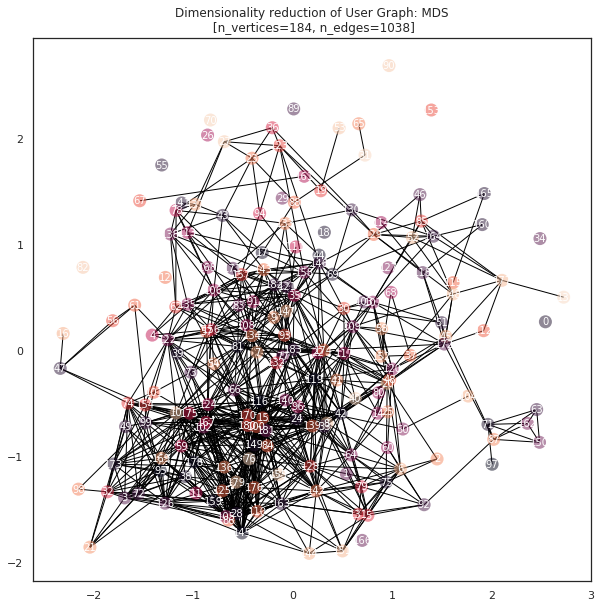

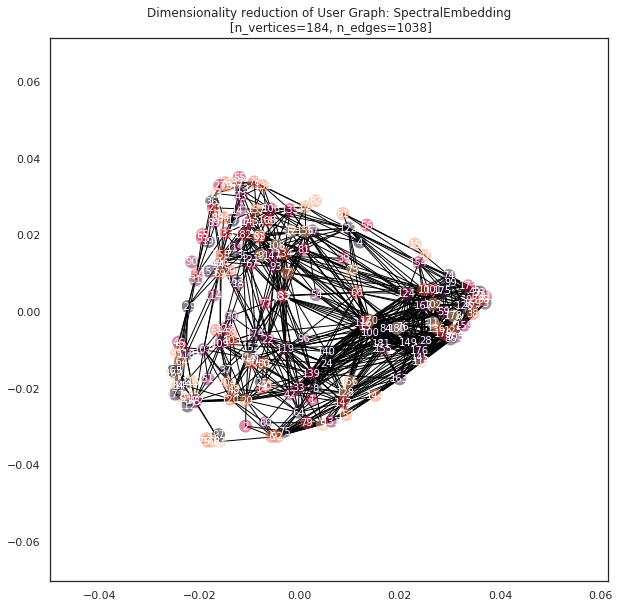

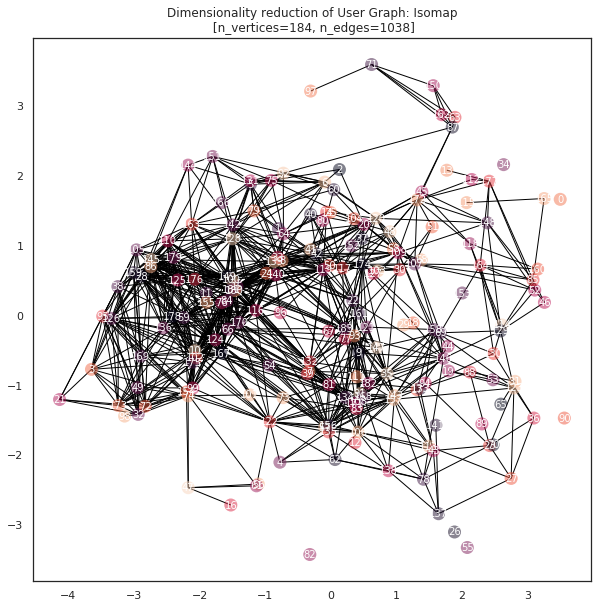

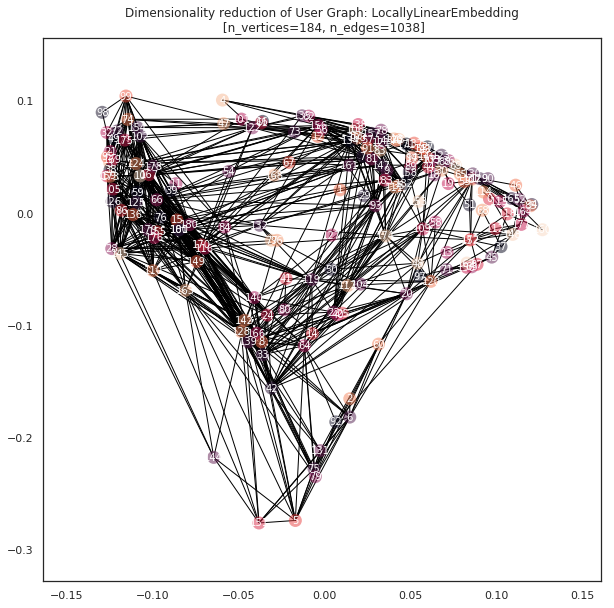

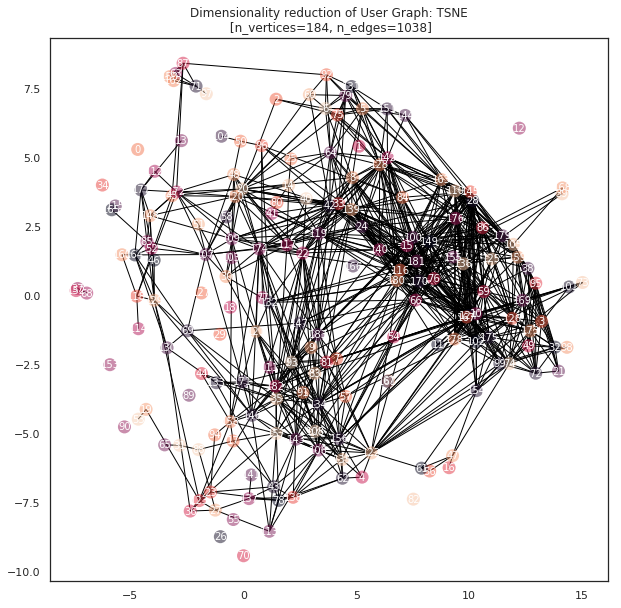

In [41]:
user_similarity_eps = epsilon_threshold_adjacency(user_similarity, 0.88)

DimRedTypes = [MDS, SpectralEmbedding, Isomap, LocallyLinearEmbedding, TSNE]
for DimRedType in DimRedTypes:
    graph = pygsp.graphs.Graph(user_similarity_eps, coords=dimensionality_reduction(DimRedType, 2, user_embeddings))
    fig, ax = graph.plot(edge_width=1, edge_color='black', vertex_size=170, vertex_color=[np.random.rand(1,len(user_embeddings))], colorbar=False, indices=True,
                        title=f"Dimensionality reduction of User Graph: {DimRedType.__name__}\n [n_vertices={graph.n_vertices}, n_edges={graph.n_edges}]")
    fig.set_figwidth(10)
    fig.set_figheight(10)

## (3.2) Item Graph

Get the latent representations for items given model and features:

In [72]:
item_biases, item_embeddings = model.get_item_representations(features=item_features)
item_biases.shape, item_embeddings.shape

((1251,), (1251, 10))

Calculate the item similarity from user embeddings using the `cosine_similarity`.

In [73]:
item_similarity = cosine_similarity(item_embeddings)
item_similarity.shape

(1251, 1251)

Plot different dimensionality reduction outputs in 2D space. In order to decrease a bit the number of edges plotted, we use epsilon threshold for adjacency matrix to get the matrix that give 1 if the similarity is above the threshold, and 0 otherwise.

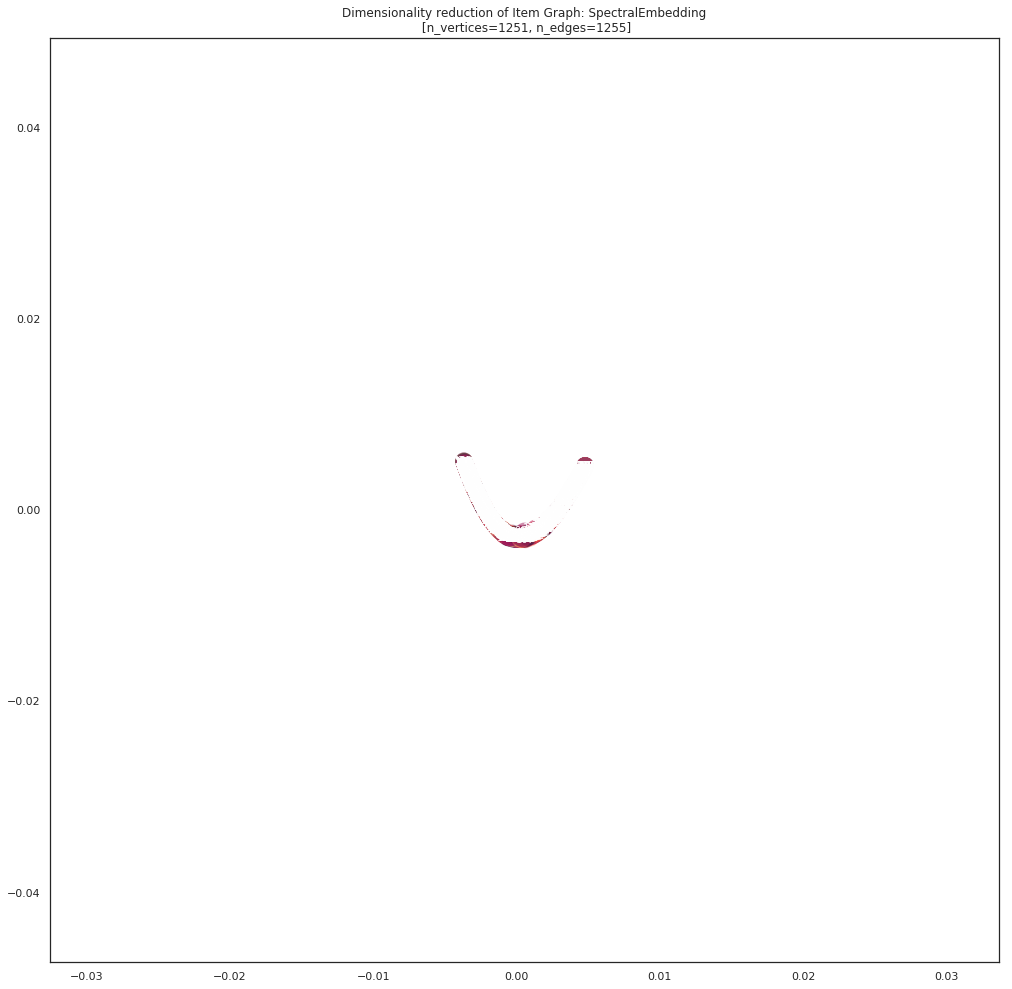

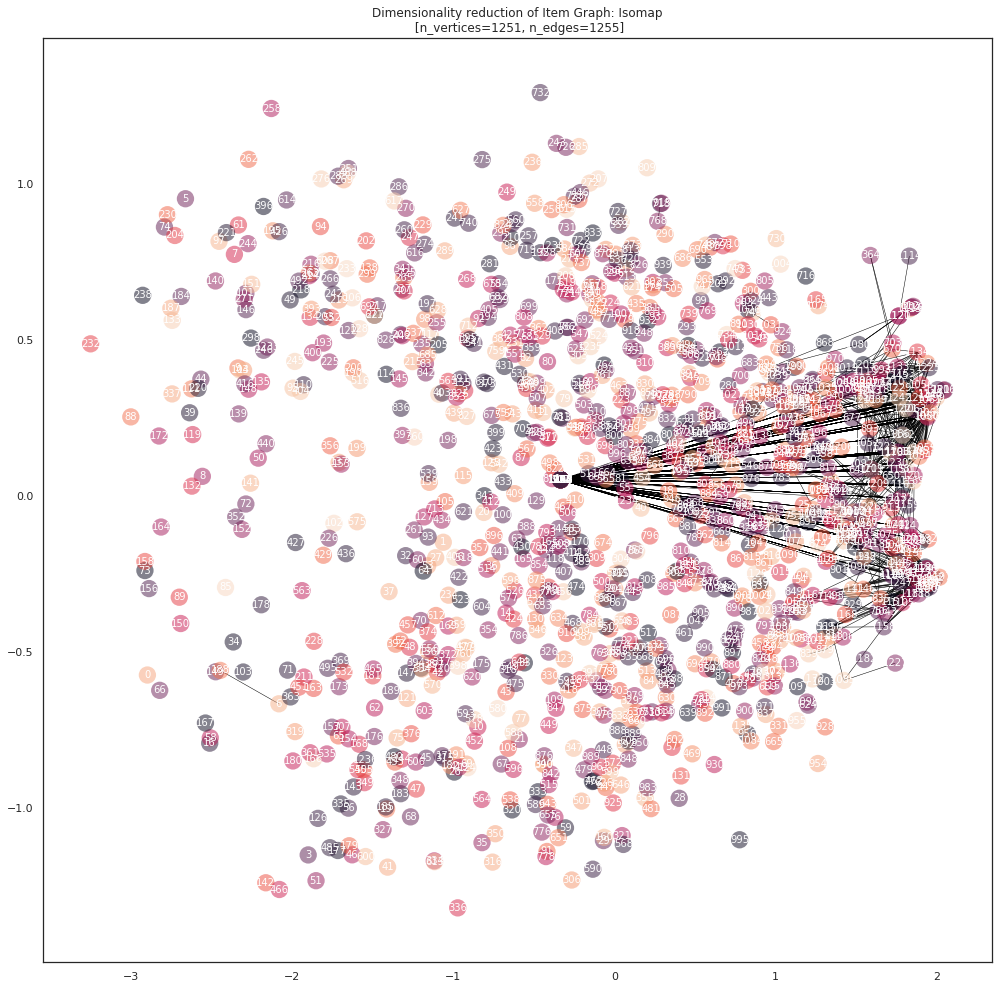

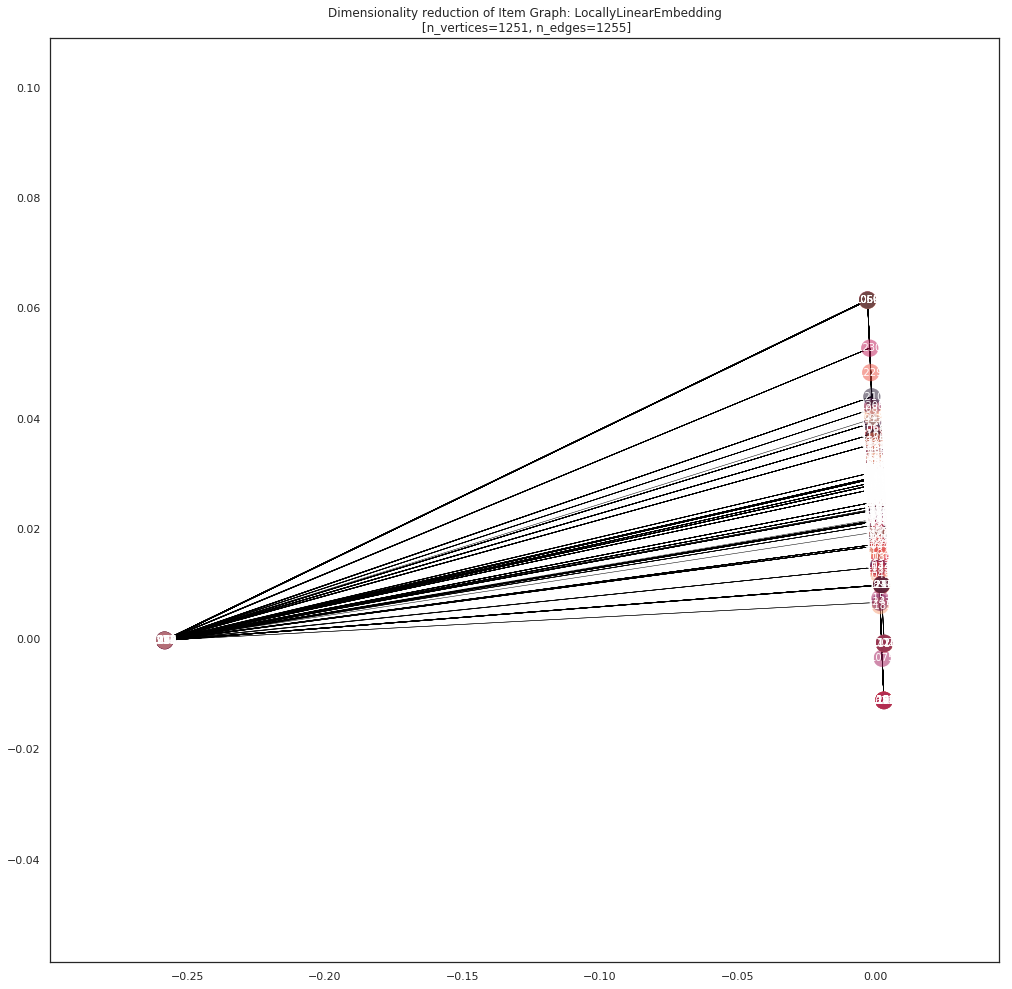

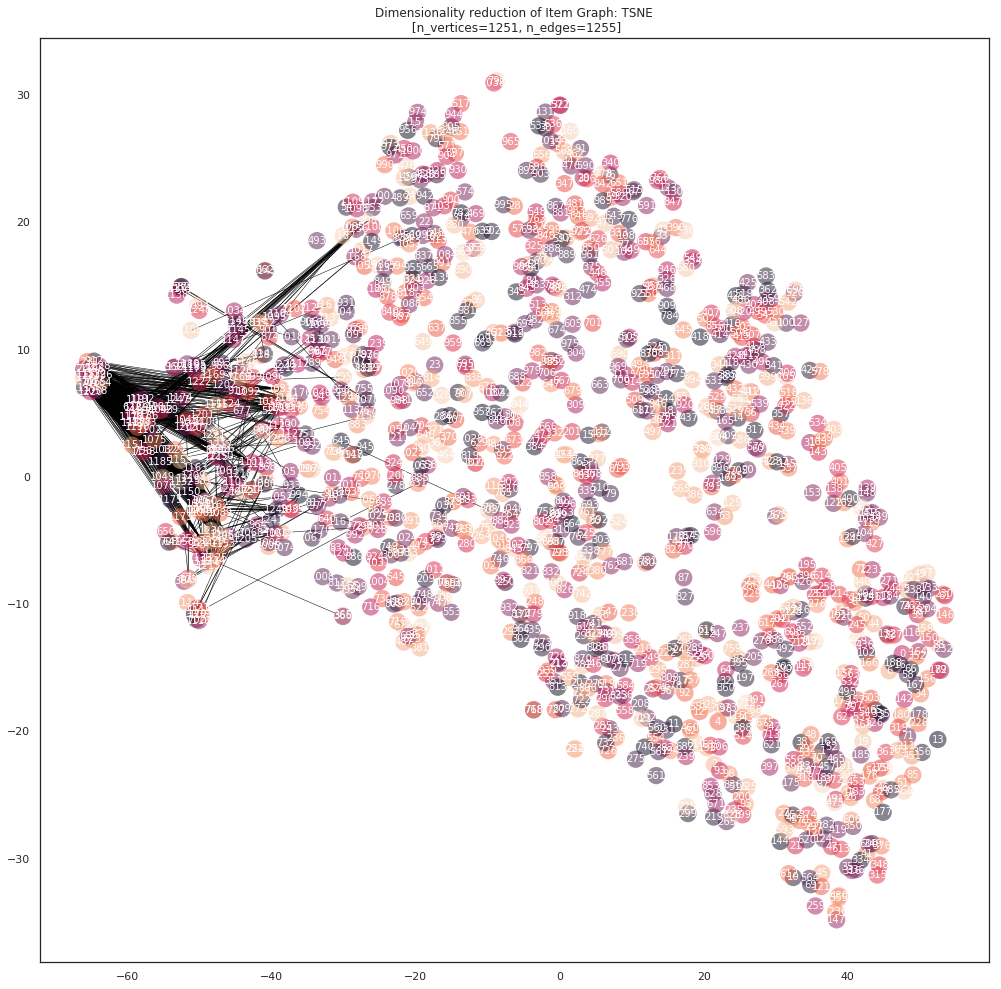

In [76]:
item_similarity_eps = epsilon_threshold_adjacency(item_similarity, threshold=0.98)

DimRedTypes = [SpectralEmbedding, Isomap, LocallyLinearEmbedding, TSNE]

for DimRedType in DimRedTypes:
    graph2 = pygsp.graphs.Graph(item_similarity_eps, coords=dimensionality_reduction(DimRedType, 2, item_embeddings))
    fig, ax = graph2.plot(edge_width=0.5, edge_color='black', vertex_size=300, vertex_color=[np.random.rand(1,len(item_embeddings))], colorbar=False, indices=True,
                        title=f"Dimensionality reduction of Item Graph: {DimRedType.__name__}\n [n_vertices={graph2.n_vertices}, n_edges={graph2.n_edges}]")
    fig.set_figwidth(17)
    fig.set_figheight(17)

Downsample the `item_embeddings` just to be able to see more:

In [80]:
idx =np.sort(random.choices(range(len(item_embeddings)), k=int(0.8*len(item_embeddings))))
item_embeddings = np.delete(item_embeddings, idx, axis=0 )
item_embeddings = np.delete(item_embeddings, idx, axis=1 ) 

/home/jelena/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  This is separate from the ipykernel package so we can avoid doing imports until


Calculate the item similarity from user embeddings using the `cosine_similarity`.

In [81]:
item_similarity = cosine_similarity(item_embeddings)
item_similarity.shape

(281, 281)

Plot different dimensionality reduction outputs in 2D space. In order to decrease a bit the number of edges plotted, we use epsilon threshold for adjacency matrix to get the matrix that give 1 if the similarity is above the threshold, and 0 otherwise.

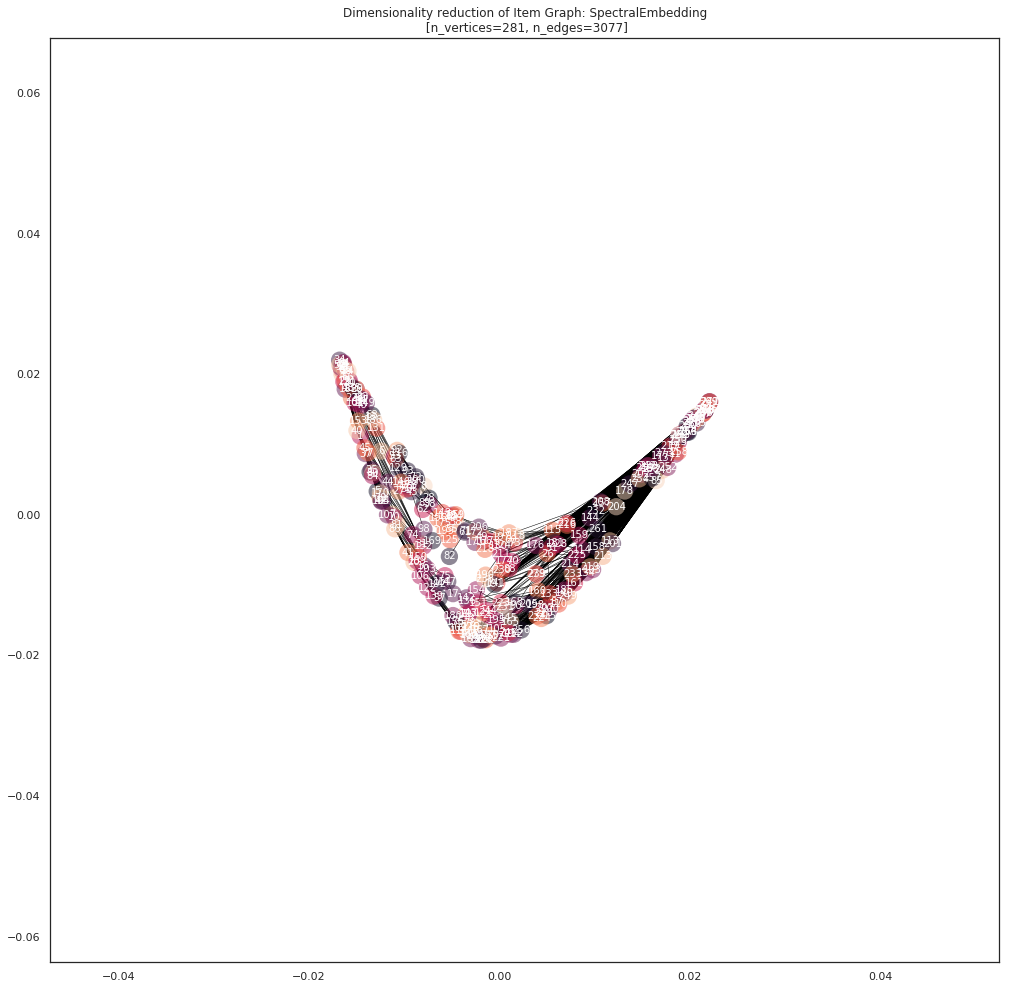

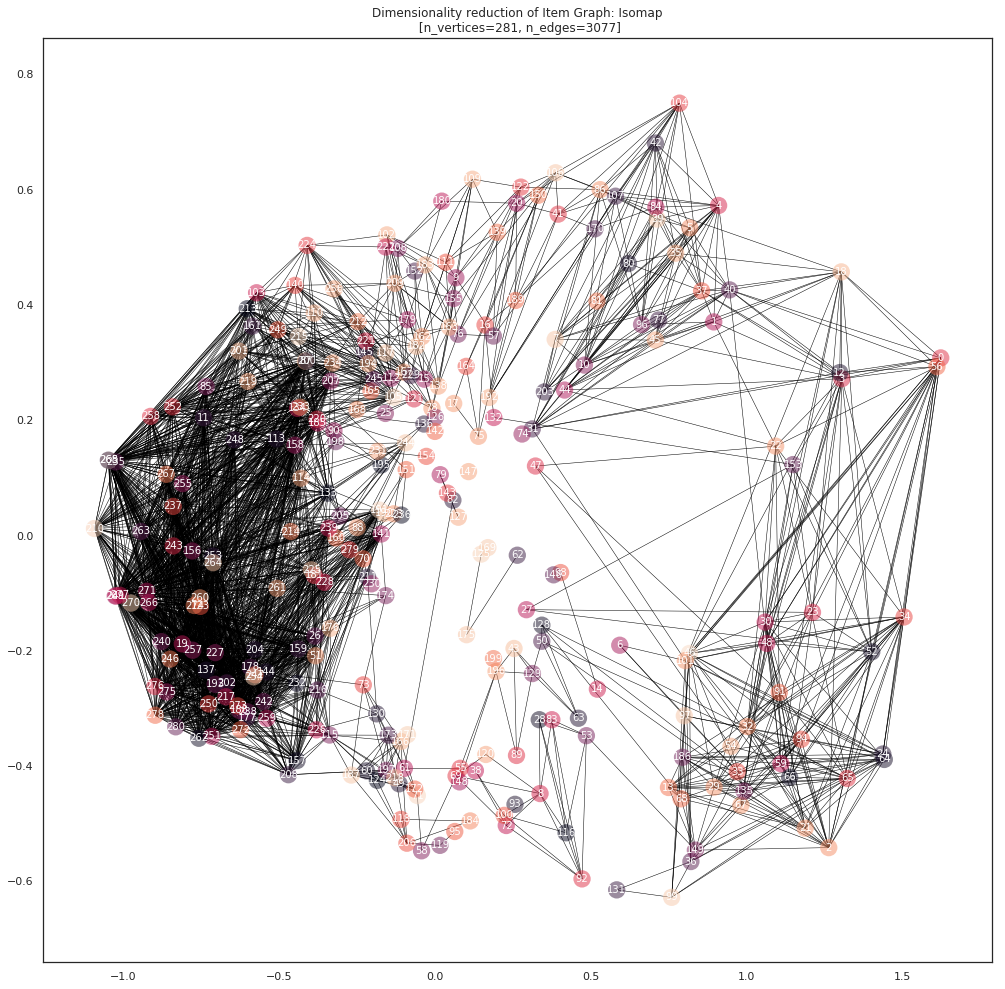

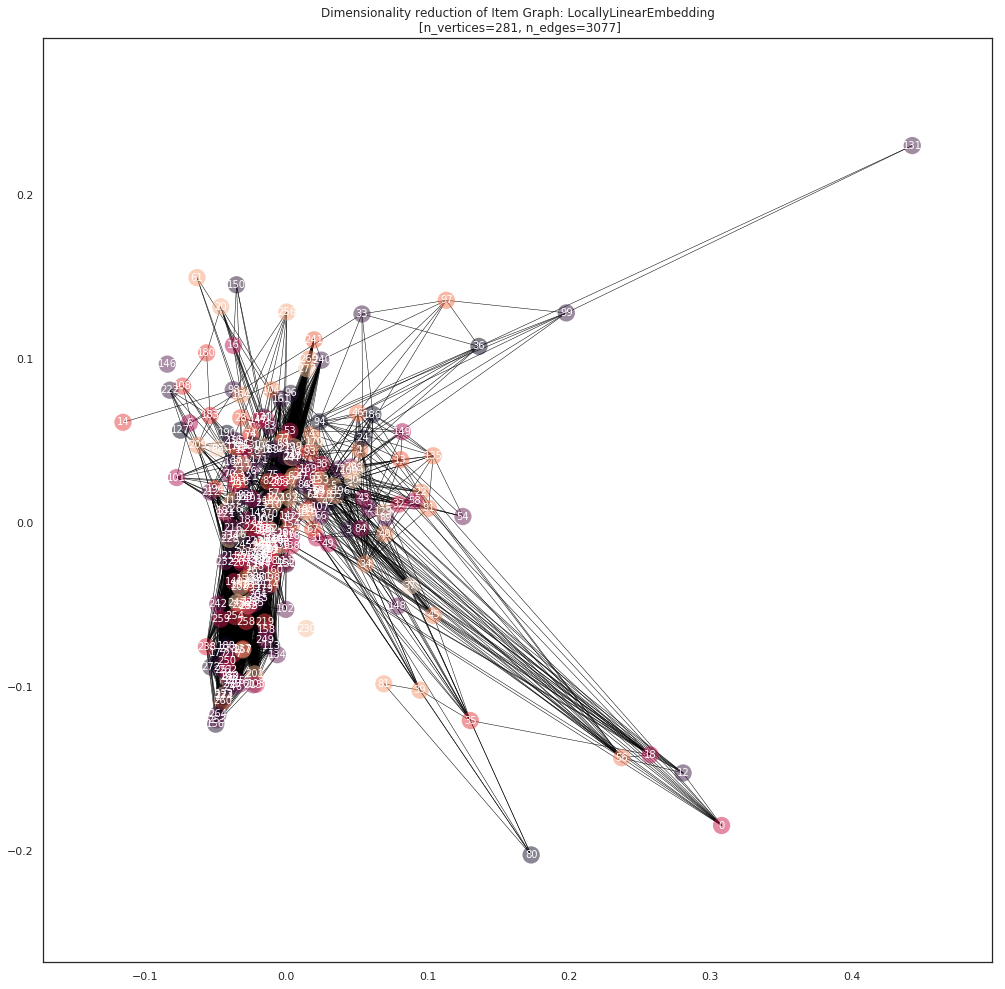

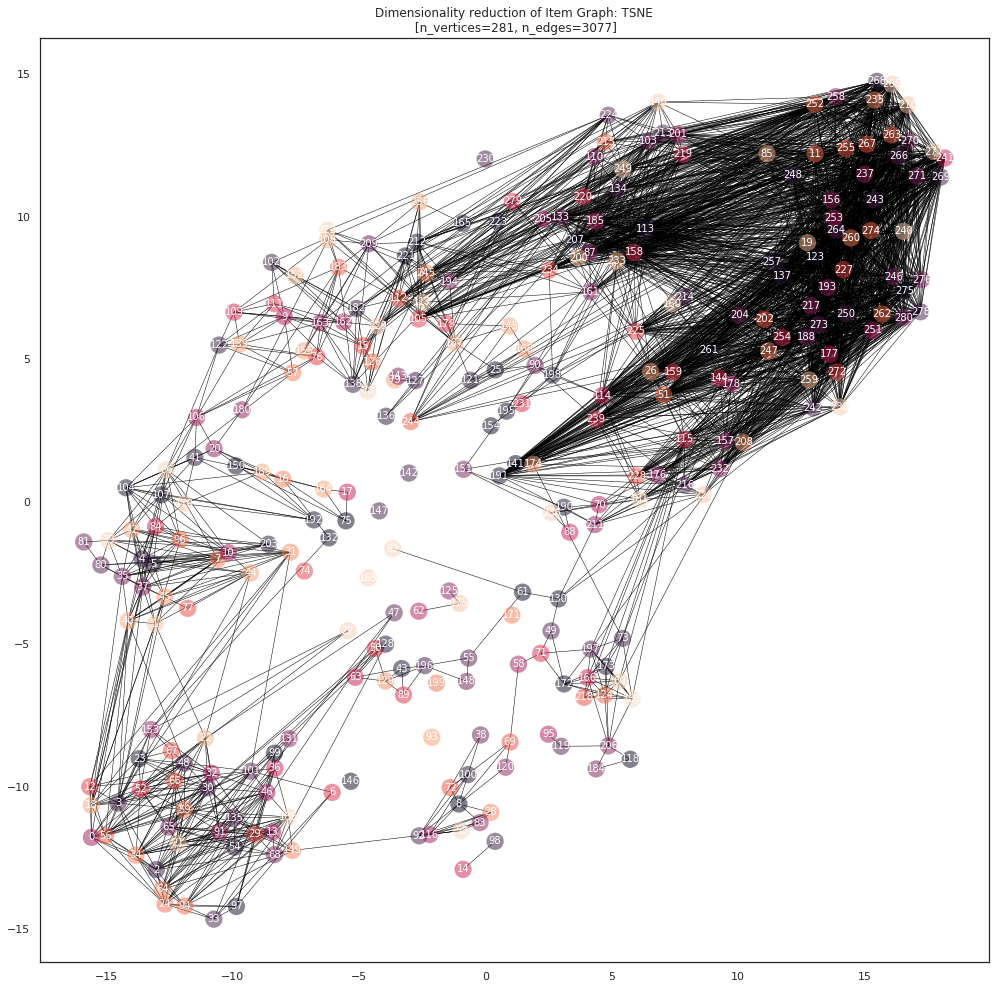

In [82]:
item_similarity_eps = epsilon_threshold_adjacency(item_similarity, threshold=0.9)

DimRedTypes = [SpectralEmbedding, Isomap, LocallyLinearEmbedding, TSNE]

for DimRedType in DimRedTypes:
    graph2 = pygsp.graphs.Graph(item_similarity_eps, coords=dimensionality_reduction(DimRedType, 2, item_embeddings))
    fig, ax = graph2.plot(edge_width=0.5, edge_color='black', vertex_size=300, vertex_color=[np.random.rand(1,len(item_embeddings))], colorbar=False, indices=True,
                        title=f"Dimensionality reduction of Item Graph: {DimRedType.__name__}\n [n_vertices={graph2.n_vertices}, n_edges={graph2.n_edges}]")
    fig.set_figwidth(17)
    fig.set_figheight(17)

---

## (4) Tests fot Hyperparameter Tuning

## (4.1) Epochs

Number of epochs to run in training.

In [45]:
test_accs = []
train_accs= []
test_precisions = []
train_precisions = []

loss_type = "warp"  # "bpr"
model = LightFM(learning_rate=0.005, loss=loss_type, max_sampled=100)

for epochs in range(10, 300, 10):
    model.fit_partial(interactions, epochs=epochs, user_features=user_features, item_features=item_features)
    #model.fit(train, epochs=50, user_features=user_features, item_features=item_features)
    train_precision = precision_at_k(model, interactions, k=10, user_features=user_features, item_features=item_features).mean()
    test_precision = precision_at_k(model, interactions_test, k=10, train_interactions=interactions, user_features=user_features, item_features=item_features).mean()

    train_auc = auc_score(model, interactions, user_features=user_features, item_features=item_features).mean()
    test_auc = auc_score(model, interactions_test, train_interactions=interactions, user_features=user_features, item_features=item_features).mean()

    #print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
    #print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

    test_accs.append(test_auc)
    train_accs.append(train_auc)
    test_precisions.append(test_precision)
    train_precisions.append(train_precision)

180
130


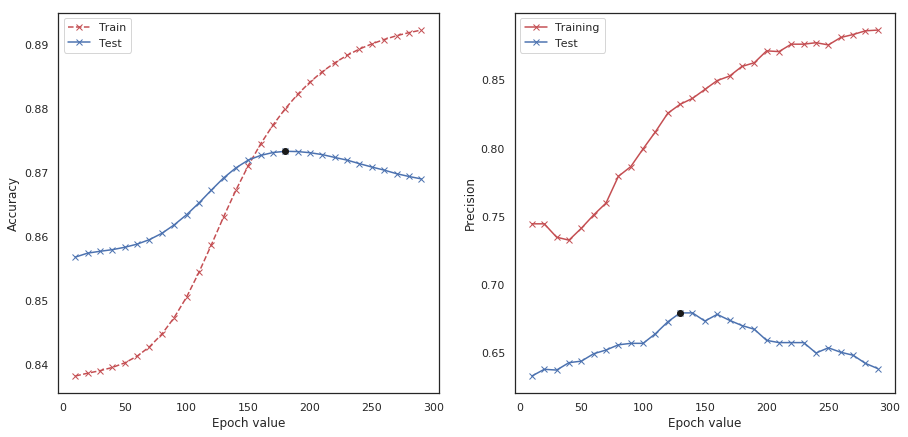

In [46]:
counts = range(10, 300, 10)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

# Visualize loss history
ax1.plot(counts, train_accs, 'r--', marker='x', label='Train')
ax1.plot(counts, test_accs, 'b-', marker='x', label='Test')
ax1.legend()
ax1.set_xlabel('Epoch value')
ax1.set_ylabel('Accuracy')
ymax = max(test_accs)
xpos = test_accs.index(ymax)
xmax = counts[xpos]
ax1.plot([xmax], [ymax], marker='o', c='k')
print(xmax)

ax2.plot(counts, train_precisions, 'r-', marker='x', label='Training')
ax2.plot(counts, test_precisions, 'b-', marker='x', label='Test')
ax2.legend()
ax2.set_xlabel('Epoch value')
ax2.set_ylabel('Precision')
ymax = max(test_precisions)
xpos = test_precisions.index(ymax)
xmax = counts[xpos]
ax2.plot([xmax], [ymax], marker='o', c='k')
print(xmax)


plt.show();

## (4.2) Learning rate

Initial learning rate for the adagrad learning schedule

In [47]:
test_accs = []
train_accs= []
test_precisions = []
train_precisions = []

epochs = 160

loss_type = "warp"  # "bpr"

for lr in np.arange(0.005, 0.5, 5e-3):
    model = LightFM(learning_rate=lr, loss=loss_type, max_sampled=100)
    
    model.fit_partial(interactions, epochs=epochs, user_features=user_features, item_features=item_features)
    train_precision = precision_at_k(model, interactions, k=10, user_features=user_features, item_features=item_features).mean()
    test_precision = precision_at_k(model, interactions_test, k=10, train_interactions=interactions, user_features=user_features, item_features=item_features).mean()

    train_auc = auc_score(model, interactions, user_features=user_features, item_features=item_features).mean()
    test_auc = auc_score(model, interactions_test, train_interactions=interactions, user_features=user_features, item_features=item_features).mean()

    #print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
    #print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

    test_accs.append(test_auc)
    train_accs.append(train_auc)
    test_precisions.append(test_precision)
    train_precisions.append(train_precision)

0.015
0.015


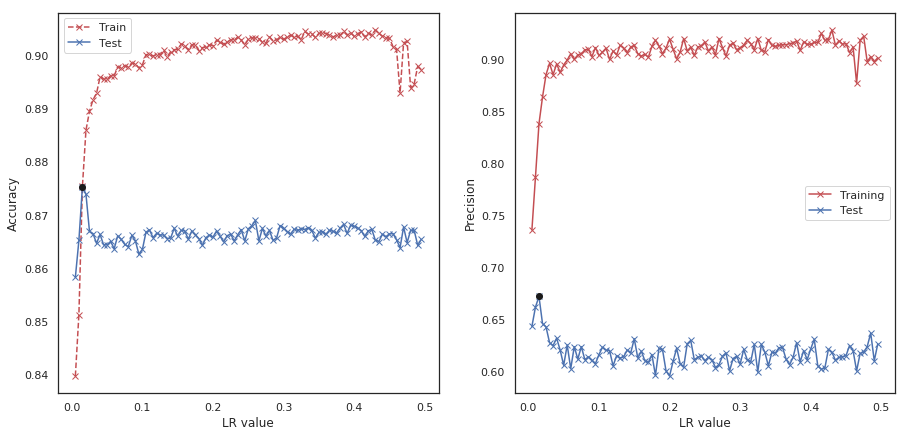

In [48]:
counts = np.arange(0.005, 0.5, 5e-3)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

# Visualize loss history
ax1.plot(counts, train_accs, 'r--', marker='x', label='Train')
ax1.plot(counts, test_accs, 'b-', marker='x', label='Test')
ax1.legend()
ax1.set_xlabel('LR value')
ax1.set_ylabel('Accuracy')
ymax = max(test_accs)
xpos = test_accs.index(ymax)
xmax = counts[xpos]
ax1.plot([xmax], [ymax], marker='o', c='k')
print(xmax)

ax2.plot(counts, train_precisions, 'r-', marker='x', label='Training')
ax2.plot(counts, test_precisions, 'b-', marker='x', label='Test')
ax2.legend()
ax2.set_xlabel('LR value')
ax2.set_ylabel('Precision')
ymax = max(test_precisions)
xpos = test_precisions.index(ymax)
xmax = counts[xpos]
ax2.plot([xmax], [ymax], marker='o', c='k')
print(xmax)


plt.show();

## (4.3) Max sampled

The maximum number of negative samples used during WARP fitting.
It requires a lot of sampling to find negative triplets for users that
are already well represented by the model; this can lead to very long
training times and overfitting. Setting this to a higher number will
generally lead to longer training times, but may in some cases improve
accuracy.

In [49]:
test_accs = []
train_accs= []
test_precisions = []
train_precisions = []

epochs = 160
lr = 0.015

loss_type = "warp"  # "bpr"

for max_sampled in np.arange(2, 100, 3):
    model = LightFM(learning_rate=lr, loss=loss_type, max_sampled=max_sampled)
    
    model.fit_partial(interactions, epochs=epochs, user_features=user_features, item_features=item_features)
    train_precision = precision_at_k(model, interactions, k=10, user_features=user_features, item_features=item_features).mean()
    test_precision = precision_at_k(model, interactions_test, k=10, train_interactions=interactions, user_features=user_features, item_features=item_features).mean()

    train_auc = auc_score(model, interactions, user_features=user_features, item_features=item_features).mean()
    test_auc = auc_score(model, interactions_test, train_interactions=interactions, user_features=user_features, item_features=item_features).mean()

    #print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
    #print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

    test_accs.append(test_auc)
    train_accs.append(train_auc)
    test_precisions.append(test_precision)
    train_precisions.append(train_precision)

2
11


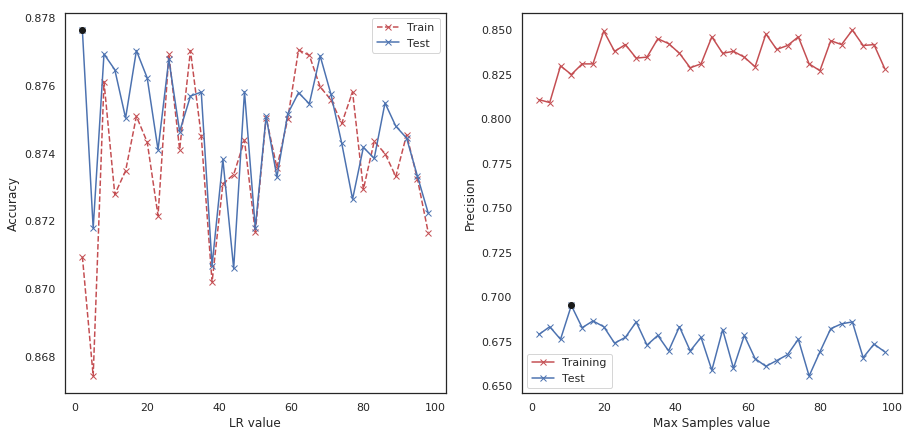

In [50]:
counts = np.arange(2, 100, 3)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

# Visualize loss history
ax1.plot(counts, train_accs, 'r--', marker='x', label='Train')
ax1.plot(counts, test_accs, 'b-', marker='x', label='Test')
ax1.legend()
ax1.set_xlabel('LR value')
ax1.set_ylabel('Accuracy')
ymax = max(test_accs)
xpos = test_accs.index(ymax)
xmax = counts[xpos]
ax1.plot([xmax], [ymax], marker='o', c='k')
print(xmax)

ax2.plot(counts, train_precisions, 'r-', marker='x', label='Training')
ax2.plot(counts, test_precisions, 'b-', marker='x', label='Test')
ax2.legend()
ax2.set_xlabel('Max Samples value')
ax2.set_ylabel('Precision')
ymax = max(test_precisions)
xpos = test_precisions.index(ymax)
xmax = counts[xpos]
ax2.plot([xmax], [ymax], marker='o', c='k')
print(xmax)


plt.show();